In [3]:
import pandas as pd
import numpy as np

from utilities import *

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from tqdm import tqdm, notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [5]:
config = load_config('../config/config.yml')
config

{'device': 'cpu',
 'seed': False,
 'model': 'rnn',
 'data': {'save': '../data/save/',
  'suppl': '../data/suppl/',
  'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/',
  'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/',
  'financials': 'financials.csv',
  'stock_prices': 'stock_prices.csv',
  'options': 'options.csv',
  'secondary_stock_price': 'secondary_stock_price.csv',
  'trades': 'trades.csv',
  'cosine': 'cosine_df.csv'},
 'sliding_window': {'max_prediction_length': 10,
  'min_prediction_length': 10,
  'max_encoder_length': 50,
  'min_encoder_length': 50,
  'batch_size': 64},
 'rnn': {'related_stock': 2},
 'gmm': {'path': './cache/', 'n_clusters': 4},
 'optimizer': {'name': 'adam',
  'epochs': 10,
  'params': {'lr': 0.001, 'regularization': 0.0001}}}

In [23]:
test_path = config['data']['test_path']
train_path = config['data']['train_path']
test_path

'../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/'

### Submission

In [20]:
submission = pd.read_csv(f'../data/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv')

In [21]:
submission.head(2)

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1


In [22]:
submission.Rank.min(), submission.Rank.max()

(0, 1999)

- Date: Date of the day to buy / short at day + 1 and quit positions at day + 2
- SecuritiesCode: Id of the stock
- Rank : Rank from 0 to 1999 of the stock for day d (top 200 are bought, lowest 200 are shorted)

## Stock prices

In [24]:
df = pd.read_csv(f'{train_path}/stock_prices.csv', parse_dates=["Date"])
df.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324


Basic values

- Open: first traded price on a day
- Close: last traded price on a day
- High: highest traded price on a day
- Low: lowest traded price on a day
- Volume: number of traded stocks on a day

### Date

In [25]:
df.groupby('SecuritiesCode').Date.apply(lambda x: (x.max() - x.min()).days)

SecuritiesCode
1301    1794
1332    1794
1333    1794
1375     442
1376    1794
        ... 
9990    1794
9991    1794
9993    1794
9994    1794
9997    1794
Name: Date, Length: 2000, dtype: int64

### AdjustmentFactor

In [26]:
df.loc[df.AdjustmentFactor >= 10].head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
108108,20170328_9470,2017-03-28,9470,317.0,317.0,312.0,315.0,82000,10.0,NaN,False,-0.006369
222875,20170627_2211,2017-06-27,2211,257.0,257.0,254.0,254.0,160000,10.0,NaN,False,-0.019432
223441,20170627_4772,2017-06-27,4772,75.0,76.0,60.0,62.0,23909000,10.0,NaN,False,0.104762


In [27]:
df.loc[(df.SecuritiesCode == 9470) & (df.Date >= '2017-03-28')]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
108108,20170328_9470,2017-03-28,9470,317.0,317.0,312.0,315.0,82000,10.0,NaN,False,-0.006369
109983,20170329_9470,2017-03-29,9470,3010.0,3180.0,3010.0,3140.0,12400,1.0,NaN,False,-0.011154
111860,20170330_9470,2017-03-30,9470,3110.0,3160.0,3110.0,3120.0,3500,1.0,NaN,False,-0.004927
113737,20170331_9470,2017-03-31,9470,3150.0,3150.0,3085.0,3085.0,8200,1.0,NaN,False,-0.009772
115614,20170403_9470,2017-04-03,9470,3100.0,3110.0,3065.0,3070.0,9000,1.0,NaN,False,-0.004868
...,...,...,...,...,...,...,...,...,...,...,...,...
2324397,20211129_9470,2021-11-29,9470,991.0,1002.0,974.0,987.0,310300,1.0,NaN,False,0.004090
2326397,20211130_9470,2021-11-30,9470,992.0,1009.0,978.0,978.0,479800,1.0,NaN,False,0.001018
2328397,20211201_9470,2021-12-01,9470,978.0,989.0,959.0,982.0,301100,1.0,NaN,False,0.031536
2330397,20211202_9470,2021-12-02,9470,978.0,1001.0,974.0,983.0,289200,1.0,NaN,False,-0.000986


In [28]:
df.loc[df.AdjustmentFactor >= 5].groupby('SecuritiesCode').AdjustmentFactor.count().value_counts()

1    217
Name: AdjustmentFactor, dtype: int64

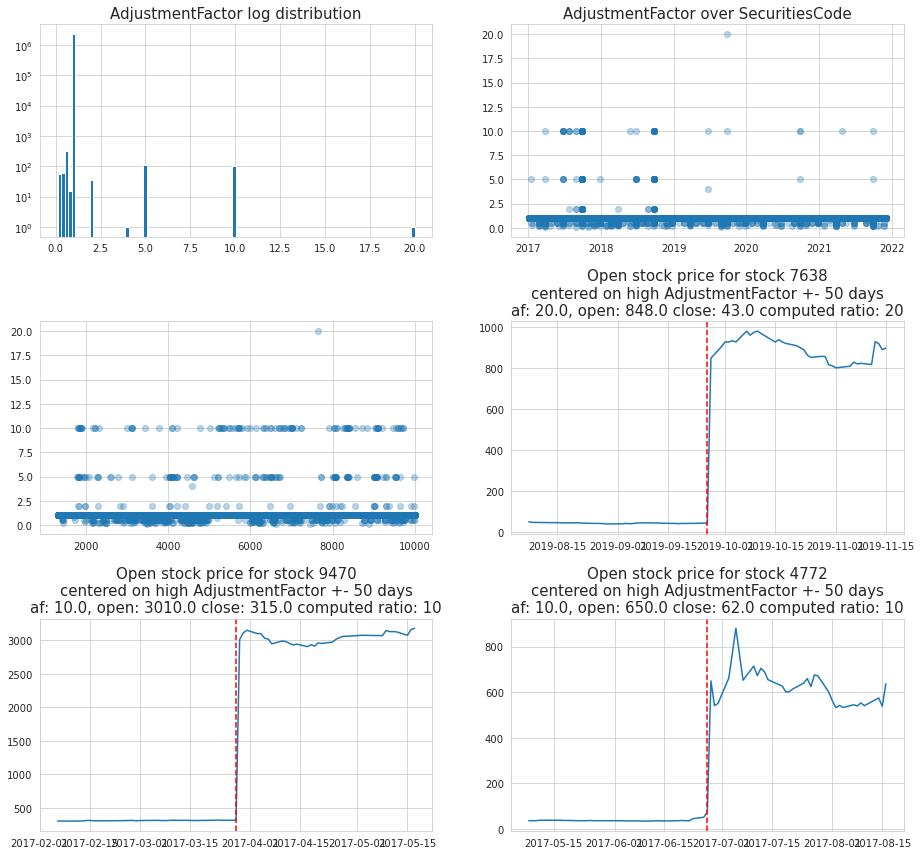

In [29]:
title_size = 15

fig, axs = plt.subplots(3, 2, figsize=(15, 14))
df.AdjustmentFactor.hist(bins=100, ax=axs[0][0], log=True)
axs[0][0].set_title('AdjustmentFactor log distribution', size=title_size)

axs[0][1].scatter(df.Date, df.AdjustmentFactor, alpha=0.3)
axs[0][1].set_title('AdjustmentFactor over time', size=title_size)

axs[1][0].scatter(df.SecuritiesCode, df.AdjustmentFactor, alpha=0.3)
axs[0][1].set_title('AdjustmentFactor over SecuritiesCode', size=title_size)


def plot_high_AdjustmentFactor(SecuritiesCode, ax, days_around=50):
    f = df.SecuritiesCode == SecuritiesCode
    
    # All stock contain only once, an AdjustmentFactor >= 5
    date = df.loc[(df.AdjustmentFactor >= 5) & (f)].Date.item()
    af = df.loc[(df.AdjustmentFactor >= 5) & (f)].AdjustmentFactor.item()
    close_d0 = df.loc[(df.AdjustmentFactor >= 5) & (f)].Close.item()
    open_d1 = df.loc[(df.Date == date + timedelta(days=1)) & (f)].Open.item()
    
    d = timedelta(days=days_around)
    f &= (df.Date >= date - d) & (df.Date <= date + d)
    ax.plot(df[f].Date, df[f].Open)
    ax.axvline(x=date, color='r', linestyle='--')
    cmp = f'\naf: {af}, open: {open_d1} close: {close_d0} computed ratio: {round(open_d1 / close_d0)}'
    ax.set_title(f'Open stock price for stock {SecuritiesCode}\ncentered on high AdjustmentFactor +- {days_around} days{cmp}', size=title_size)

plot_high_AdjustmentFactor(7638, axs[1, 1])
plot_high_AdjustmentFactor(9470, axs[2, 0])
plot_high_AdjustmentFactor(4772, axs[2, 1])

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.show()

- AdjustmentFactor: To calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares/)



To understand why these big bumps happen, we need to understand what is a split / reverse stock split 

*A reverse stock split occurs when a publicly traded company divides the number of outstanding shares by a certain amount. This serves to decrease the number of outstanding shares and increase the price per share of those outstanding shares. This differs from a forward stock split where the number of shares increases, and the share price declines post-split.*

source: https://www.bankrate.com/investing/reverse-stock-split/#:~:text=A%20reverse%20stock%20split%20occurs,share%20of%20those%20outstanding%20shares.

__More details to use adjustment factors__: https://www.kaggle.com/code/kevinmontes/using-adjustment-factors

### ExpectedDividend

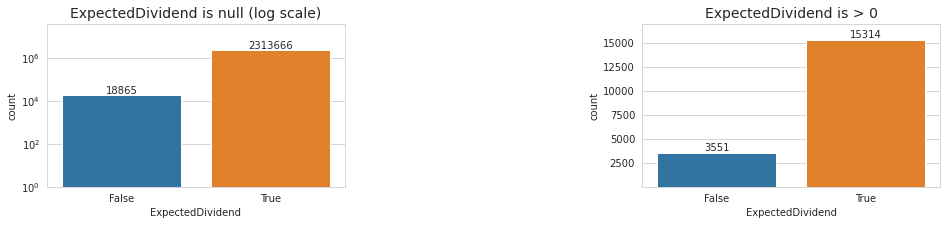

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(16, 3))

ax = sns.countplot(x=df.ExpectedDividend.isna(), log=True, ax=axs[0])
ax.set_title('ExpectedDividend is null (log scale)', fontsize=14)

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{p.get_height()}', (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

ax.set_ylim(1, 40000000)

# Is equal to 0

ax = sns.countplot(x=df[df.ExpectedDividend.notna()].ExpectedDividend > 0, log=False, ax=axs[1])
ax.set_title('ExpectedDividend is > 0', fontsize=14)

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(text=f'{p.get_height()}', xy=(x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

ax.set_ylim(1, 17000)

plt.subplots_adjust(wspace=1)

plt.show()

In [31]:
df['Date_day_month'] = df.Date.progress_apply(lambda x: datetime(day=x.day, month=x.month, year=2000))


  0%|          | 0/2332531 [00:00<?, ?it/s]

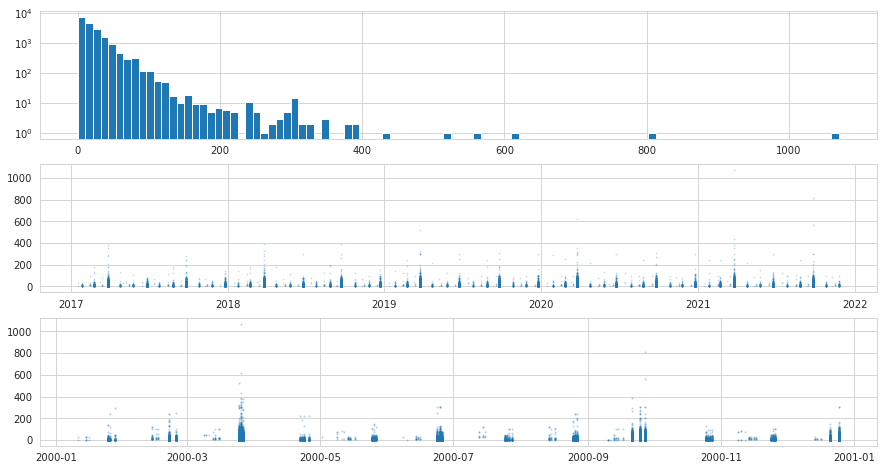

In [32]:
fig, axs = plt.subplots(3, 1, figsize=(15, 8))

df.ExpectedDividend.hist(bins=100, ax=axs[0], log=True)
axs[1].scatter(df.Date, df.ExpectedDividend, alpha=0.2, s=0.6)

axs[2].scatter(df.Date_day_month, df.ExpectedDividend, alpha=0.2, s=1.5)
plt.show()

- ExpectedDividend: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.

### SupervisionFlag

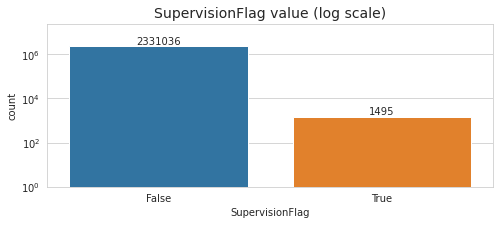

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3))

ax = sns.countplot(x=df.SupervisionFlag, log=True, ax=axs)
ax.set_title('SupervisionFlag value (log scale)', fontsize=14)

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{p.get_height()}', (x.mean(), y), 
            ha='center', va='bottom')

ax.set_ylim(1, 24000000)
plt.show()

In [34]:
df[df.SupervisionFlag == True].head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Date_day_month
92438,20170315_6502,2017-03-15,6502,199.9,205.5,186.5,189.5,379973000,1.0,NaN,True,0.035403,2000-03-15
94305,20170316_6502,2017-03-16,6502,188.6,192.2,181.6,183.6,211415000,1.0,NaN,True,0.033666,2000-03-16
96172,20170317_6502,2017-03-17,6502,198.0,199.0,186.3,190.1,237833000,1.0,NaN,True,-0.012723,2000-03-17
98042,20170321_6502,2017-03-21,6502,187.0,197.1,186.5,196.5,124884000,1.0,NaN,True,0.068557,2000-03-21
99914,20170322_6502,2017-03-22,6502,194.0,195.7,192.4,194.0,54887000,1.0,NaN,True,0.075736,2000-03-22


In [35]:
df[df.SupervisionFlag == True].groupby('SecuritiesCode').SupervisionFlag.sum()

SecuritiesCode
2729     22
3001     19
3540    989
3919     33
4526     10
4699      1
5008     42
5486    147
6067      8
6465      9
6470      9
6502    143
6637      2
7868     57
8806      4
Name: SupervisionFlag, dtype: int64

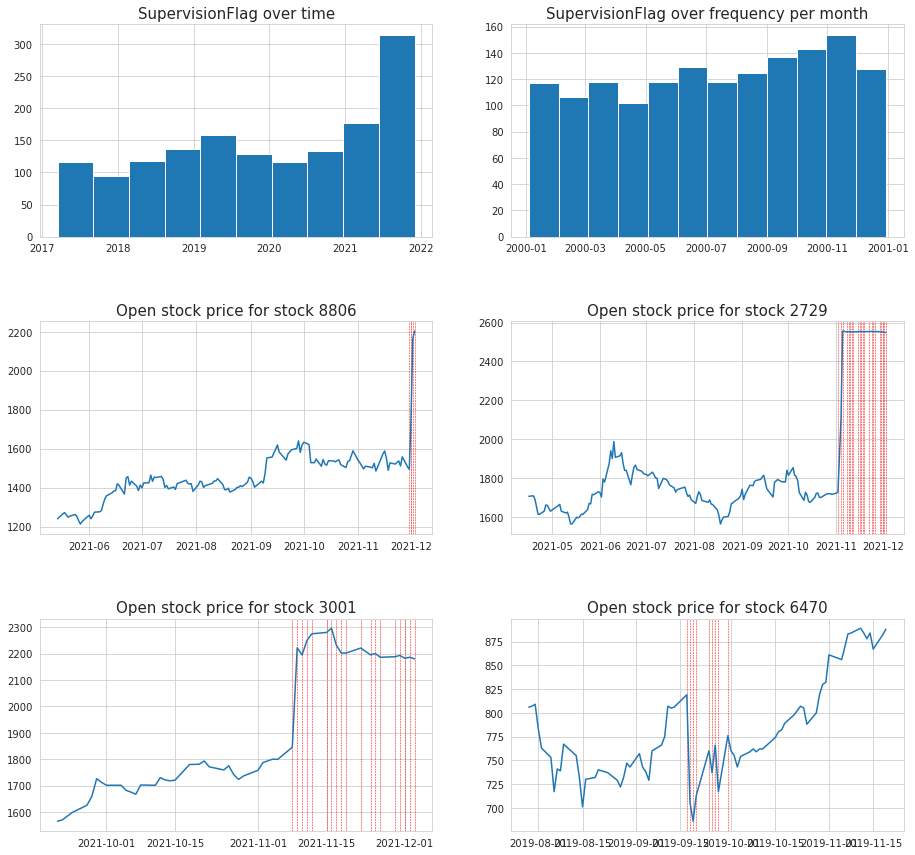

In [36]:
title_size = 15

fig, axs = plt.subplots(3, 2, figsize=(15, 14))

axs[0][0].hist(df[df.SupervisionFlag == True].Date)
axs[0][0].set_title('SupervisionFlag over time', size=title_size)

axs[0][1].hist(df[df.SupervisionFlag == True].Date_day_month, bins=12)
axs[0][1].set_title('SupervisionFlag over frequency per month', size=title_size)
# axs[0][1].set_xticks(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])


def plot_security_flag(SecuritiesCode, ax, days_around=50):
    f = df.SecuritiesCode == SecuritiesCode
    
    dates = df.loc[(df.SupervisionFlag == True) & (f)].Date
    date_min = None
    date_max = None
    
    for date in dates:
#         print(date)
        date_min = date if (date_min is None or date < date_min) else date_min
        date_max = date if (date_max is None or date > date_max) else date_max
        ax.axvline(x=date, color='r', linestyle='--', linewidth=.5)
        
    
    d = timedelta(days=days_around)
    f &= (df.Date >= date_min - d) & (df.Date <= date_max + d)
    ax.plot(df[f].Date, df[f].Open)
    ax.set_title(f'Open stock price for stock {SecuritiesCode}', size=title_size)

plot_security_flag(8806, axs[1, 0], 200)
plot_security_flag(2729, axs[1, 1], 200)
plot_security_flag(3001, axs[2, 0])
plot_security_flag(6470, axs[2, 1])

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9,
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.show()

- SupervisionFlag: Flag of Securities Under Supervision & Securities to Be Delisted https://www.jpx.co.jp/english/listing/market-alerts/supervision/00-archives/index.html

### Target
The value used for evaluation is **Target**, let's see how this is computed

In [37]:
# Select random stock
f = df.SecuritiesCode == 1301

diff_ = df[f].Close.diff()
close_shifted_right = df[f].Close.shift(1)



pd.DataFrame({'(close t - t-1)': diff_, 
              '(close t - t-1) / close t-1': diff_.values / close_shifted_right.values,
              'target (close t+2 - t+1) / close t+1)': df[f].Target.values,
              'Close': df[f].Close.values,
              })

,(close t - t-1),(close t - t-1) / close t-1,target (close t+2 - t+1) / close t+1),Close
0,NaN,NaN,0.000730,2742.0
1865,-4.0,-0.001459,0.002920,2738.0
3730,2.0,0.000730,-0.001092,2740.0
5595,8.0,0.002920,-0.005100,2748.0
7460,-3.0,-0.001092,-0.003295,2745.0
...,...,...,...,...
2322531,-44.0,-0.014691,0.003793,2951.0
2324531,-51.0,-0.017282,0.007558,2900.0
2326531,11.0,0.003793,0.016706,2911.0
2328531,22.0,0.007558,-0.003689,2933.0


Values of columns 2 and 3 are equal with 2 days delay as expected

- Target: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is TradeDate. Adjusted using close value of t+1